# 1. Classify CIFAR-10 Dataset(with VGG-19 & resnet)

50000 training images<br>
10000 validation images<br>
<br>
for more info, https://www.cs.toronto.edu/~kriz/cifar.html<br> 

## 1-0. Define dataset & dataloader

In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [ ]:
from google.colab import drive
import os


drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/수업/20211224(CNN)') 

Mounted at /content/drive


In [ ]:
batch_size =64
learning_rate = 0.0001
num_epochs = 1

train_dataset = datasets.CIFAR10(root='./data/',
                                 train=True,
                                 transform=transforms.ToTensor(),
                                 download=True
                                 )

test_dataset = datasets.CIFAR10(root='./data/',
                                train=False,
                                transform=transforms.ToTensor()
                                )

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True
                                           )

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True
                                          )

Files already downloaded and verified


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def show_cifar10():
    for images, _ in train_loader:
        plt.figure(figsize=(8,8))
        images_to_show = images.numpy().transpose((0,2,3,1))

        for a in range(331, 340):  
            plt.subplot(a)
            plt.imshow(images_to_show[a-331])
            plt.xticks([])
            plt.yticks([])
            plt.show()   
        break
    return 0


def loss_plot(acc):  
    plt.plot(acc)
    plt.xlabel('log')
    plt.ylabel('accuracy')
    plt.grid(True)
    plt.show()
    return 0

import time
class Timer():    
    def __init__(self):
        self.cur_t = time.time()

    def tic(self):
        self.cur_t = time.time()

    def toc(self):
        return time.time() - self.cur_t

    def tocStr(self, t=-1):
        if (t == -1):
            return str(datetime.timedelta(seconds=np.round(time.time() - self.cur_t, 3)))[:-4]
        else:
            return str(datetime.timedelta(seconds=np.round(t, 3)))[:-4]
          

def test_on_cifar10(model, accuracy_list):
    model.eval()
    correct = 0
    total = 0
    for j, (images, labels) in enumerate(test_loader):
        images = images.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum()
        if (j+1)%100==0:
            break

    print('Test Accuracy of the model on the 100 test images: %d %%' % (100 * correct.float() / total))
    accuracy_list.append(100 * correct.float() / total) 
    return accuracy_list

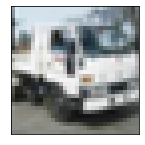

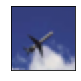

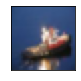

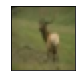

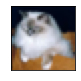

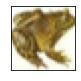

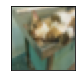

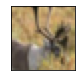

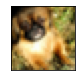

0

In [ ]:
show_cifar10()

## 1-1. Use [VGG-19](https://iq.opengenus.org/

vgg19-architecture/) model

### Define Model

In [ ]:
class ConvBlock1(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super(ConvBlock1, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim

        self.main = nn.Sequential(nn.Conv2d(self.in_dim, self.out_dim, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(self.out_dim),
                                  nn.ReLU(),
                                  nn.Conv2d(self.out_dim, self.out_dim, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(self.out_dim),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2),
                                  )
        
    def forward(self, x):
        out = self.main(x)
        return out

In [ ]:
class ConvBlock2(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super(ConvBlock2, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim

        self.main = nn.Sequential(nn.Conv2d(self.in_dim, self.out_dim, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(self.out_dim),
                                  nn.ReLU(),
                                  nn.Conv2d(self.out_dim, self.out_dim, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(self.out_dim),
                                  nn.ReLU(),
                                  nn.Conv2d(self.out_dim, self.out_dim, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(self.out_dim),
                                  nn.ReLU(),
                                  nn.Conv2d(self.out_dim, self.out_dim, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(self.out_dim),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2),
                                  )
        
    def forward(self, x):
        out = self.main(x)
        return out

In [ ]:
class VGG19(nn.Module):
    
    def __init__(self):
        super(VGG19, self).__init__()
        self.convlayer1 = ConvBlock1(3, 64)
        self.convlayer2 = ConvBlock1(64, 128)
        self.convlayer3 = ConvBlock2(128, 256)
        self.convlayer4 = ConvBlock2(256, 512)
        self.convlayer5 = ConvBlock2(512, 512)
        self.linear = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
            )
        
    def forward(self, input):
        out = self.convlayer1(input)
        out = self.convlayer2(out)
        out = self.convlayer3(out)
        out = self.convlayer4(out)
        out = self.convlayer5(out).squeeze()
        out = self.linear(out)
        return out

In [ ]:
# check model is well defined
vgg19 = VGG19().cuda()
print(vgg19)

sample_image = torch.zeros(64, 3, 32, 32).cuda()
output = vgg19(sample_image)
print(output.size())

VGG19(
  (convlayer1): ConvBlock1(
    (main): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (convlayer2): ConvBlock1(
    (main): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2,

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
if count_parameters(vgg19) == 20365002:
    print('success!')

success!


### Train Model

Epoch [1/1], Iter [100/781], Loss: 1.5615, iter_time: 3.52
Test Accuracy of the model on the 100 test images: 35 %
Epoch [1/1], Iter [200/781], Loss: 1.8631, iter_time: 5.11
Test Accuracy of the model on the 100 test images: 33 %
Epoch [1/1], Iter [300/781], Loss: 1.6428, iter_time: 5.09
Test Accuracy of the model on the 100 test images: 36 %
Epoch [1/1], Iter [400/781], Loss: 1.4831, iter_time: 5.10
Test Accuracy of the model on the 100 test images: 40 %
Epoch [1/1], Iter [500/781], Loss: 1.3425, iter_time: 5.09
Test Accuracy of the model on the 100 test images: 44 %
Epoch [1/1], Iter [600/781], Loss: 1.3676, iter_time: 5.10
Test Accuracy of the model on the 100 test images: 45 %
Epoch [1/1], Iter [700/781], Loss: 1.4012, iter_time: 5.10
Test Accuracy of the model on the 100 test images: 49 %


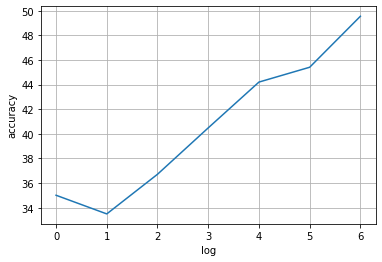

In [ ]:
import torchvision.models as models

tell_time = Timer()
iter_time = 0
accuracy_list = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg19.parameters(), lr=learning_rate) # learning_rate = 0.001

for epoch in range(num_epochs):
    vgg19.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.cuda()
        labels = labels.cuda()

        # Foward
        optimizer.zero_grad()
        outputs = vgg19(images)
        # Backward
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], Iter [%d/%d], Loss: %.4f, iter_time: %2.2f'%(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.item(), tell_time.toc()-iter_time))
            iter_time = tell_time.toc()
            accuracy_list = test_on_cifar10(vgg19, accuracy_list)
        
    loss_plot(accuracy_list)

### Use pre_trained VGG-19

In [ ]:
import torchvision.models as models


pre_vgg = models.vgg19_bn(pretrained=True)

In [ ]:
pre_vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
a = torch.zeros((4,3,32,32))
pre_vgg.features(a).shape

torch.Size([4, 512, 1, 1])

In [ ]:
class PretrainedVgg(nn.Module):
    def __init__(self, pre_vgg):
        super(PretrainedVgg, self).__init__()
        self.features = nn.Sequential(
            *list(pre_vgg.features.children())
        )
        self.linear = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )
    
    def forward(self, x):
        out = self.features(x).squeeze()
        out = self.linear(out)
        return out

Epoch [1/1], Iter [100/781], Loss: 0.9971, iter_time: 3.47
Test Accuracy of the model on the 100 test images: 69 %
Epoch [1/1], Iter [200/781], Loss: 0.8412, iter_time: 5.11
Test Accuracy of the model on the 100 test images: 71 %
Epoch [1/1], Iter [300/781], Loss: 0.5034, iter_time: 5.09
Test Accuracy of the model on the 100 test images: 77 %
Epoch [1/1], Iter [400/781], Loss: 0.6849, iter_time: 5.09
Test Accuracy of the model on the 100 test images: 79 %
Epoch [1/1], Iter [500/781], Loss: 0.6804, iter_time: 5.08
Test Accuracy of the model on the 100 test images: 79 %
Epoch [1/1], Iter [600/781], Loss: 0.5596, iter_time: 5.09
Test Accuracy of the model on the 100 test images: 83 %
Epoch [1/1], Iter [700/781], Loss: 0.7125, iter_time: 5.09
Test Accuracy of the model on the 100 test images: 82 %


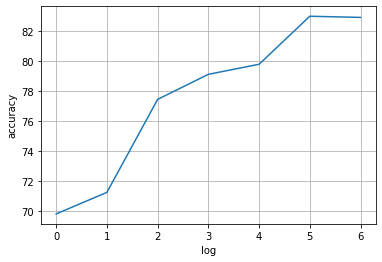

In [ ]:
vgg19 = PretrainedVgg(pre_vgg).cuda()

tell_time = Timer()
iter_time = 0
accuracy_list = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg19.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    vgg19.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.cuda()
        labels = labels.cuda()

        # Forward
        optimizer.zero_grad()
        outputs = vgg19(images)
        # Backward
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], Iter [%d/%d], Loss: %.4f, iter_time: %2.2f'%(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.item(), tell_time.toc()-iter_time))
            iter_time = tell_time.toc()
            accuracy_list = test_on_cifar10(vgg19, accuracy_list)
        
    loss_plot(accuracy_list)

## 1-2. Use [resnet](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py) model

In [ ]:
resnet18 = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
a = torch.zeros((64,3,32,32))
o = resnet18(a)
print(o.shape)

torch.Size([64, 1000])


In [ ]:
# check layers
test_layers = nn.Sequential(   
            *list(resnet18.children())
        )
for i in range(len(test_layers)):
    o = test_layers[:i](a)
    print(i, o.shape)

0 torch.Size([64, 3, 32, 32])
1 torch.Size([64, 64, 16, 16])
2 torch.Size([64, 64, 16, 16])
3 torch.Size([64, 64, 16, 16])
4 torch.Size([64, 64, 8, 8])
5 torch.Size([64, 64, 8, 8])
6 torch.Size([64, 128, 4, 4])
7 torch.Size([64, 256, 2, 2])
8 torch.Size([64, 512, 1, 1])
9 torch.Size([64, 512, 1, 1])


In [ ]:
test_layers

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
class PretrainedResnet(nn.Module):
    def __init__(self, resnet18):
        super(PretrainedResnet, self).__init__()
        self.features = nn.Sequential(
            *list(resnet18.children())
        )
        self.features = self.features[:7]

        self.linear = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        out = self.features(x).view(-1, 256 * 2 * 2)
        out = self.linear(out)
        return out

In [ ]:
# set hyperparameters
learning_rate = 0.00005
num_epochs = 2

Epoch [1/2], Iter [100/781] Loss: 1.5696, iter_time: 1.67
Test Accuracy of the model on the 100 test images: 53 %
Epoch [1/2], Iter [200/781] Loss: 0.9001, iter_time: 2.49
Test Accuracy of the model on the 100 test images: 63 %
Epoch [1/2], Iter [300/781] Loss: 0.6139, iter_time: 2.46
Test Accuracy of the model on the 100 test images: 70 %
Epoch [1/2], Iter [400/781] Loss: 0.8144, iter_time: 2.48
Test Accuracy of the model on the 100 test images: 72 %
Epoch [1/2], Iter [500/781] Loss: 0.7716, iter_time: 2.48
Test Accuracy of the model on the 100 test images: 73 %
Epoch [1/2], Iter [600/781] Loss: 0.7512, iter_time: 2.47
Test Accuracy of the model on the 100 test images: 73 %
Epoch [1/2], Iter [700/781] Loss: 0.6958, iter_time: 2.45
Test Accuracy of the model on the 100 test images: 74 %


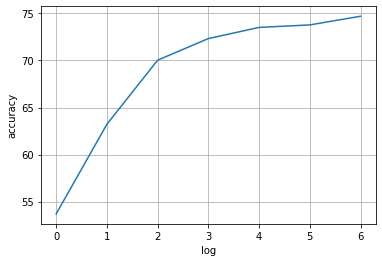

Epoch [2/2], Iter [100/781] Loss: 0.8667, iter_time: 3.96
Test Accuracy of the model on the 100 test images: 74 %
Epoch [2/2], Iter [200/781] Loss: 0.5585, iter_time: 2.46
Test Accuracy of the model on the 100 test images: 76 %
Epoch [2/2], Iter [300/781] Loss: 0.9662, iter_time: 2.47
Test Accuracy of the model on the 100 test images: 77 %
Epoch [2/2], Iter [400/781] Loss: 0.5972, iter_time: 2.47
Test Accuracy of the model on the 100 test images: 78 %
Epoch [2/2], Iter [500/781] Loss: 0.7319, iter_time: 2.47
Test Accuracy of the model on the 100 test images: 76 %
Epoch [2/2], Iter [600/781] Loss: 0.5412, iter_time: 2.45
Test Accuracy of the model on the 100 test images: 76 %
Epoch [2/2], Iter [700/781] Loss: 0.4023, iter_time: 2.47
Test Accuracy of the model on the 100 test images: 78 %


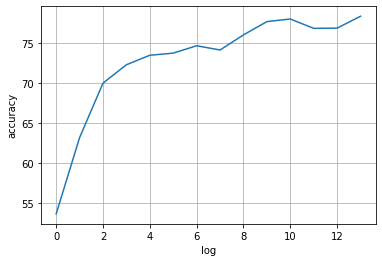

In [ ]:
resnet = PretrainedResnet(resnet18).cuda()

tell_time = Timer()
iter_time = 0
accuracy_list = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    resnet.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.cuda()
        labels = labels.cuda()

        # Forward
        optimizer.zero_grad()
        outputs = resnet(images)
        # Backward
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f, iter_time: %2.2f' 
                 %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.item(), tell_time.toc()-iter_time))
            iter_time = tell_time.toc()    
            accuracy_list = test_on_cifar10(resnet, accuracy_list)

    loss_plot(accuracy_list)

# 2. Classify COCO val Dataset(with official YOLO5)

공식 [튜토리얼](https://github.com/ultralytics/yolov5/blob/master/tutorial.ipynb)을 다뤘으므로 생략 

<a align="left" href="https://ultralytics.com/yolov5" target="_blank">
<img width="1024", src="https://user-images.githubusercontent.com/26833433/125273437-35b3fc00-e30d-11eb-9079-46f313325424.png"></a>

This is the **official YOLOv5 🚀 notebook** by **Ultralytics**, and is freely available for redistribution under the [GPL-3.0 license](https://choosealicense.com/licenses/gpl-3.0/). 
For more information please visit https://github.com/ultralytics/yolov5 and https://ultralytics.com. Thank you!

# 3. Classify Pascal VOC 2007 dataset(with UNet)

![UNet](https://drive.google.com/uc?export=view&id=1scmhSKYgyHC70_1caI_QsYUMFgMTAg9s)

In [1]:
import os
import sys
print(os.getcwd())
!ls

/content
sample_data


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import albumentations as A
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision.transforms.functional import to_tensor
from torchvision.utils import save_image

In [3]:
from google.colab import drive
drive.mount('./MyDrive')

Mounted at ./MyDrive


## 3-0. Define dataset & dataloader

In [4]:
!tar -xvf "/content/MyDrive/MyDrive/Colab Notebooks/수업/20211227(Image classify and detect)/data/VOCtrainval_06-Nov-2007.tar"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
VOCdevkit/VOC2007/JPEGImages/001732.jpg
VOCdevkit/VOC2007/JPEGImages/001733.jpg
VOCdevkit/VOC2007/JPEGImages/001734.jpg
VOCdevkit/VOC2007/JPEGImages/001738.jpg
VOCdevkit/VOC2007/JPEGImages/001739.jpg
VOCdevkit/VOC2007/JPEGImages/001741.jpg
VOCdevkit/VOC2007/JPEGImages/001746.jpg
VOCdevkit/VOC2007/JPEGImages/001747.jpg
VOCdevkit/VOC2007/JPEGImages/001749.jpg
VOCdevkit/VOC2007/JPEGImages/001750.jpg
VOCdevkit/VOC2007/JPEGImages/001752.jpg
VOCdevkit/VOC2007/JPEGImages/001754.jpg
VOCdevkit/VOC2007/JPEGImages/001755.jpg
VOCdevkit/VOC2007/JPEGImages/001756.jpg
VOCdevkit/VOC2007/JPEGImages/001758.jpg
VOCdevkit/VOC2007/JPEGImages/001759.jpg
VOCdevkit/VOC2007/JPEGImages/001761.jpg
VOCdevkit/VOC2007/JPEGImages/001765.jpg
VOCdevkit/VOC2007/JPEGImages/001766.jpg
VOCdevkit/VOC2007/JPEGImages/001768.jpg
VOCdevkit/VOC2007/JPEGImages/001771.jpg
VOCdevkit/VOC2007/JPEGImages/001772.jpg
VOCdevkit/VOC2007/JPEGImages/001775.jpg
VOCdevkit/VOC2007/JPEGImages/001777.jpg
VOCd

In [5]:
# For download pascal voc 2007 dataset
from torchvision.datasets import VOCSegmentation


project_path = './'
VOCSegmentation(root=os.path.join(project_path, 'data'), year='2007', download=True)

  0%|          | 0/460032000 [00:00<?, ?it/s]

Extracting ./data/VOCtrainval_06-Nov-2007.tar to ./data


Dataset VOCSegmentation
    Number of datapoints: 209
    Root location: ./data

In [12]:
class DatasetFromFolderVOC(Dataset):
    def __init__(self, root_dir=os.path.join(project_path,'data/VOCdevkit/VOC2007'), txt_file='train.txt', transforms=None):
        super(DatasetFromFolderVOC, self).__init__()
        with open(os.path.join(root_dir, 'ImageSets/Segmentation', txt_file), 'r') as f:
            self.filenames = f.readlines()
        self.filenames = [file.strip() for file in self.filenames]
        self.img_path = os.path.join(root_dir, "JPEGImages")
        self.gt_path = os.path.join(root_dir, "SegmentationClass")
        self.transforms = transforms
        self.pallete = Image.open(os.path.join(self.gt_path, f'{self.filenames[0]}.png')).getpalette()


    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_path, f'{self.filenames[index]}.jpg')).convert('RGB')
        gt = Image.open(os.path.join(self.gt_path, f'{self.filenames[index]}.png'))

        aug = self.transforms(image=np.array(img), mask=np.array(gt))
        img = to_tensor(aug['image'])
        gt = aug['mask']
        gt[gt > 20] = 0
        gt = torch.tensor(gt)

        return img, gt


    def __len__(self):
        return len(self.filenames)

In [13]:
transform = A.Compose([A.Resize(512, 512)])

dataset = DatasetFromFolderVOC(transforms=transform)
img, gt = dataset[0]
pallete = dataset.pallete

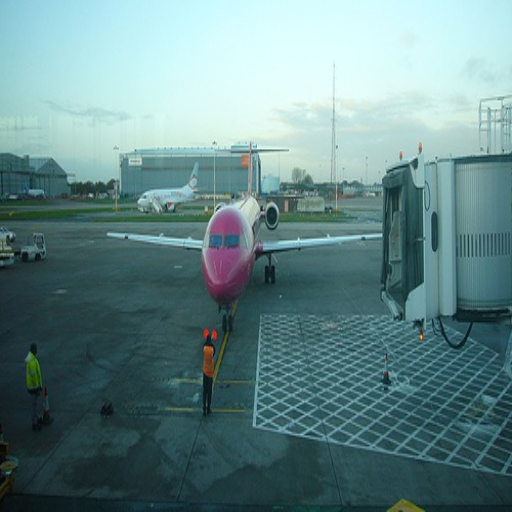

In [16]:
tf = transforms.ToPILImage()
tf(img)

In [18]:
gt_img = tf(gt)
gt_img.putpalette(dataset.pallete)

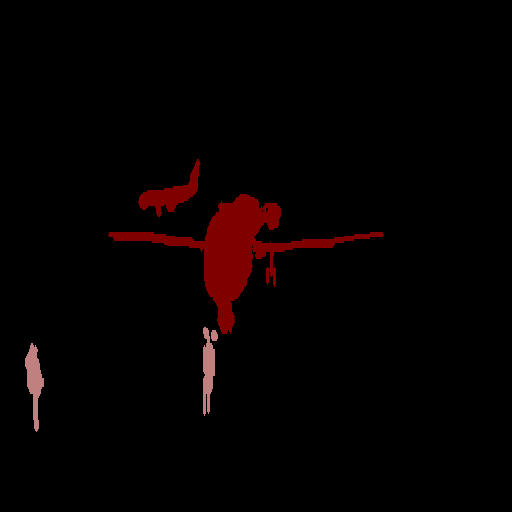

In [19]:
gt_img

In [20]:
from torch.utils.data import DataLoader


transform = A.Compose([A.Resize(256, 256), A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5), A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

train_set = DatasetFromFolderVOC(txt_file='train.txt', transforms=transform)
val_set = DatasetFromFolderVOC(txt_file='val.txt', transforms=transform)

train_dataloader = DataLoader(dataset=train_set, num_workers=2, batch_size=8, shuffle=True)
val_dataloader = DataLoader(dataset=val_set, num_workers=1, batch_size=1, shuffle=False)

## 3-1. Use [UNet](https://github.com/milesial/Pytorch-UNet)

### Define Model

In [35]:
# conv block((Conv + BatchNorm + ReLU) * 2)
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    

    def forward(self, x):
        x = self.double_conv(x)
        
        return x

In [36]:
# down block(Downsampling + Conv)
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels),
        )
    
    def forward(self, x):
        x = self.maxpool_conv(x)

        return x

In [37]:
# up block(Upsampling + Conv)
class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv = ConvBlock(in_channels, out_channels, int(in_channels/2))
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        
        return x

In [38]:
# last block
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    
    def forward(self, x):
        x = self.conv(x)
        
        return x

In [39]:
# Make UNet
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = ConvBlock(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [40]:
num_classes = 21  # 20 + background
model = UNet(3, num_classes)

input = torch.zeros((1,3,512,512))
output = model(input)
print(input.shape, output.shape) # torch.Size([1, 3, 512, 512]) torch.Size([1, 21, 512, 512])

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


torch.Size([1, 3, 512, 512]) torch.Size([1, 21, 512, 512])


### Train Model

In [43]:
import torch.optim as optim
from tqdm import tqdm



model = model.cuda().train()
criterion = nn.CrossEntropyLoss()
# setup optimizer
# optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=1e-5, betas=(0.9, 0.999))

total_epoch = 1

# Training
for epoch in range(total_epoch):
    for i, (img, gt) in enumerate(train_dataloader):
        img = img.cuda()
        gt = gt.long().cuda()

        # forward and calculate the loss
        pred = model(img)
        loss = criterion(pred, gt)

        # Backprop + Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 10 == 0:        
            print(f'[{epoch+1}][{i+1}/{len(train_dataloader)}] Loss: {loss.item():.3f}')


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


[1][1/27] Loss: 3.226
[1][11/27] Loss: 3.176
[1][21/27] Loss: 3.111


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


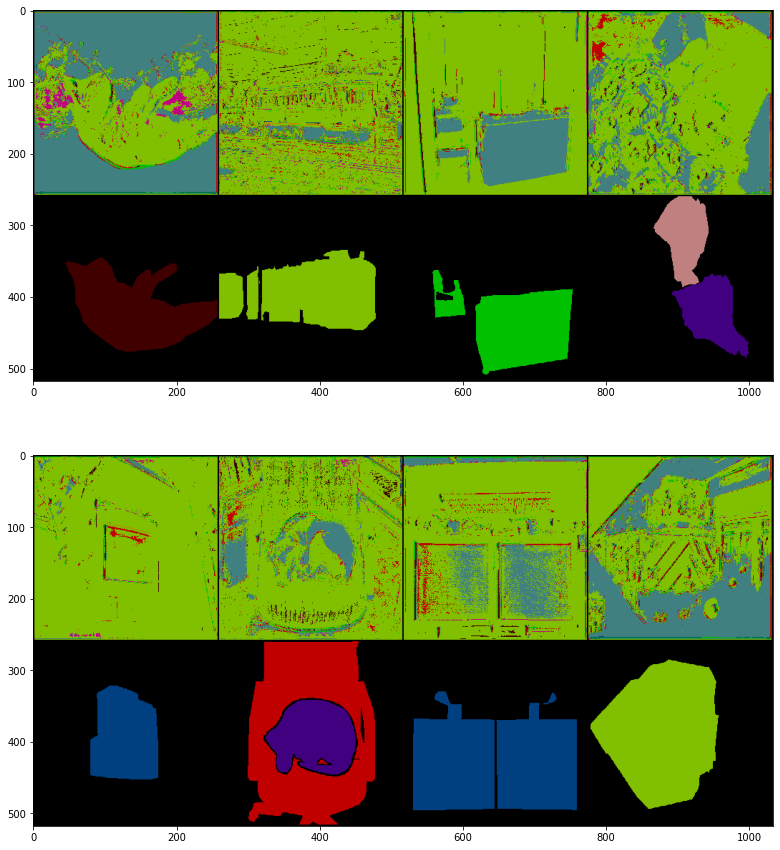

In [46]:
# Visualization
model.eval()
num_imgs = 4
preds_train, gts_train = None, None
preds_val, gts_val = None, None
for i, (img, gt) in enumerate(train_dataloader):
    if i * train_dataloader.batch_size >= num_imgs:
        break
    with torch.no_grad():
        # forward
        img = img.cuda()
        gt = gt.long().cuda()
        pred = model(img)
        output_pred = pred.argmax(1)
        for j in range(min(train_dataloader.batch_size, 4)):
            out_img = Image.fromarray(np.array(output_pred[j].cpu()).astype('uint8'))
            out_img.putpalette(train_set.pallete)
            out_img = to_tensor(out_img.convert('RGB')).unsqueeze(0)
            preds_train = out_img if i == 0 and j == 0 else torch.cat([preds_train, out_img])
            out_img = Image.fromarray(np.array(gt[j].cpu()).astype('uint8'))
            out_img.putpalette(train_set.pallete)
            out_img = to_tensor(out_img.convert('RGB')).unsqueeze(0)
            gts_train = out_img if i == 0 and j == 0 else torch.cat([gts_train, out_img])
            
for i, (img, gt) in enumerate(val_dataloader):
    if i * val_dataloader.batch_size >= num_imgs:
        break
    with torch.no_grad():
        # forward
        img = img.cuda()
        gt = gt.long().cuda()
        pred = model(img)
        output_pred = pred.argmax(1)
        for j in range(min(val_dataloader.batch_size, num_imgs)):
            out_img = Image.fromarray(np.array(output_pred[j].cpu()).astype('uint8'))
            out_img.putpalette(val_set.pallete)
            out_img = to_tensor(out_img.convert('RGB')).unsqueeze(0)
            preds_test = out_img if i == 0 and j == 0 else torch.cat([preds_test, out_img])
            out_img = Image.fromarray(np.array(gt[j].cpu()).astype('uint8'))
            out_img.putpalette(val_set.pallete)
            out_img = to_tensor(out_img.convert('RGB')).unsqueeze(0)
            gts_test = out_img if i == 0 and j == 0 else torch.cat([gts_test, out_img])

train_samples = torch.cat([preds_train.cpu(), gts_train])
train_samples = torchvision.utils.make_grid(train_samples, nrow=num_imgs)
train_samples = train_samples.permute(1, 2, 0)

test_samples = torch.cat([preds_test.cpu(), gts_test])
test_samples = torchvision.utils.make_grid(test_samples, nrow=num_imgs)
test_samples = test_samples.permute(1, 2, 0)

plt.rcParams["figure.figsize"] = (30, 15)
plt.subplot(2, 1, 1)
plt.imshow(train_samples)
plt.subplot(2, 1, 2)
plt.imshow(test_samples)

### Use pre_trained UNet

In [47]:
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import numpy as np

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


  0%|          | 0.00/161M [00:00<?, ?B/s]

2022-01-03 13:05:41 URL:https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg [182965/182965] -> "bird.png" [1]


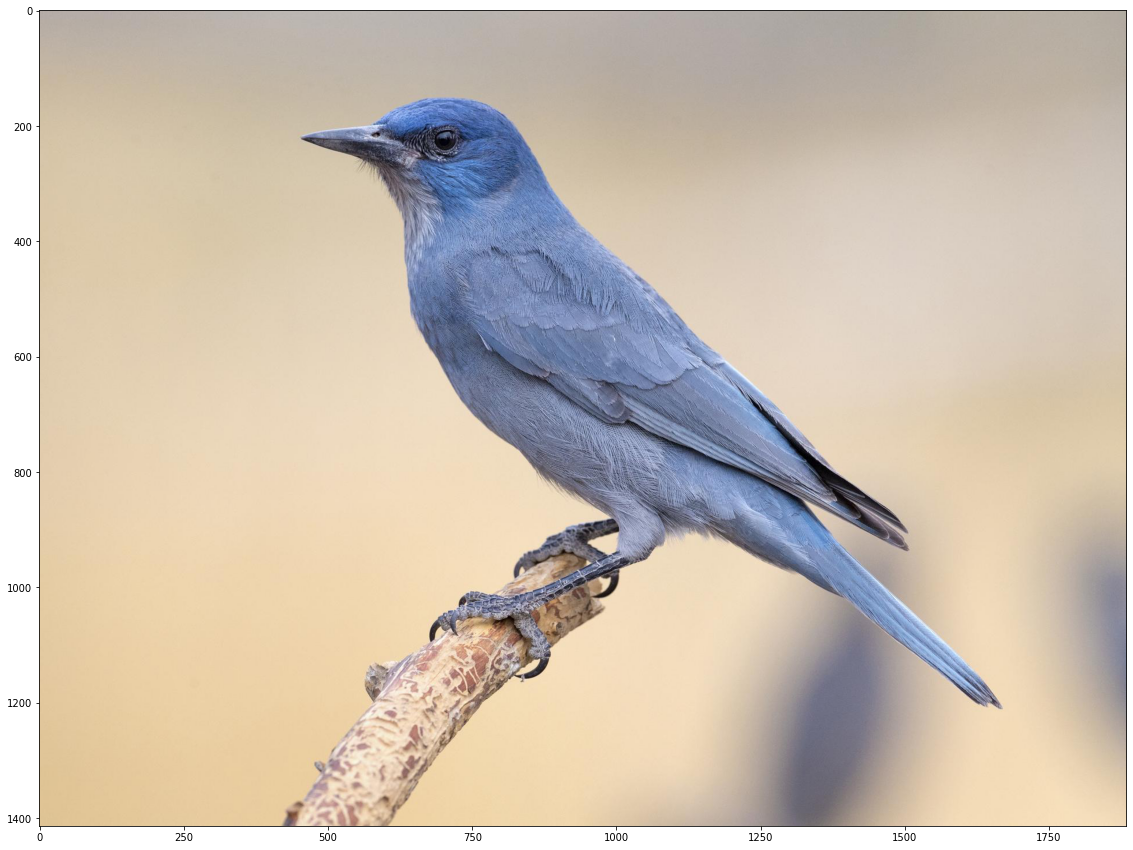

torch.Size([1, 21, 224, 224])
(224, 224)
[0 3]


In [48]:
deeplabv3 = models.segmentation.deeplabv3_resnet50(pretrained=True).eval()


!wget -nv https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/04/10/19/pinyon-jay-bird.jpg -O bird.png
img = Image.open('./bird.png')
plt.imshow(img); plt.show()

trf = T.Compose([T.Resize(256),
                 T.CenterCrop(224),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
inp = trf(img).unsqueeze(0)
# Pass the input through the net
out = deeplabv3(inp)['out']
print (out.shape)

om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (om.shape)
print (np.unique(om))

In [49]:
def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

In [50]:
def segment(net, path, show_orig=True, dev='cuda'):
  img = Image.open(path)
  if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
  # Comment the Resize and CenterCrop for better inference results
  trf = T.Compose([T.Resize(640), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0).to(dev)
  out = net.to(dev)(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  rgb = decode_segmap(om)
  plt.imshow(rgb); plt.axis('off'); plt.show()

2022-01-03 13:05:55 URL:https://www.learnopencv.com/wp-content/uploads/2021/01/horse-segmentation.jpeg [434252/434252] -> "horse.png" [1]


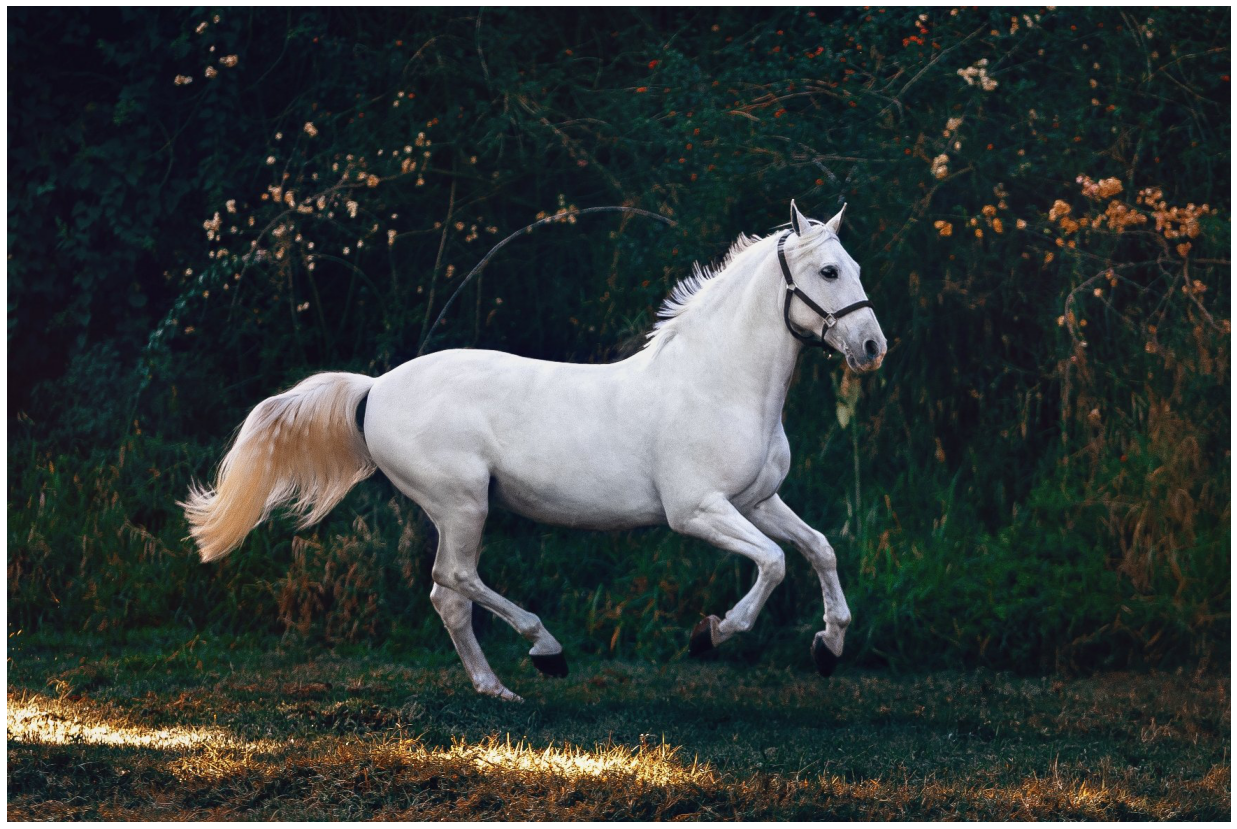

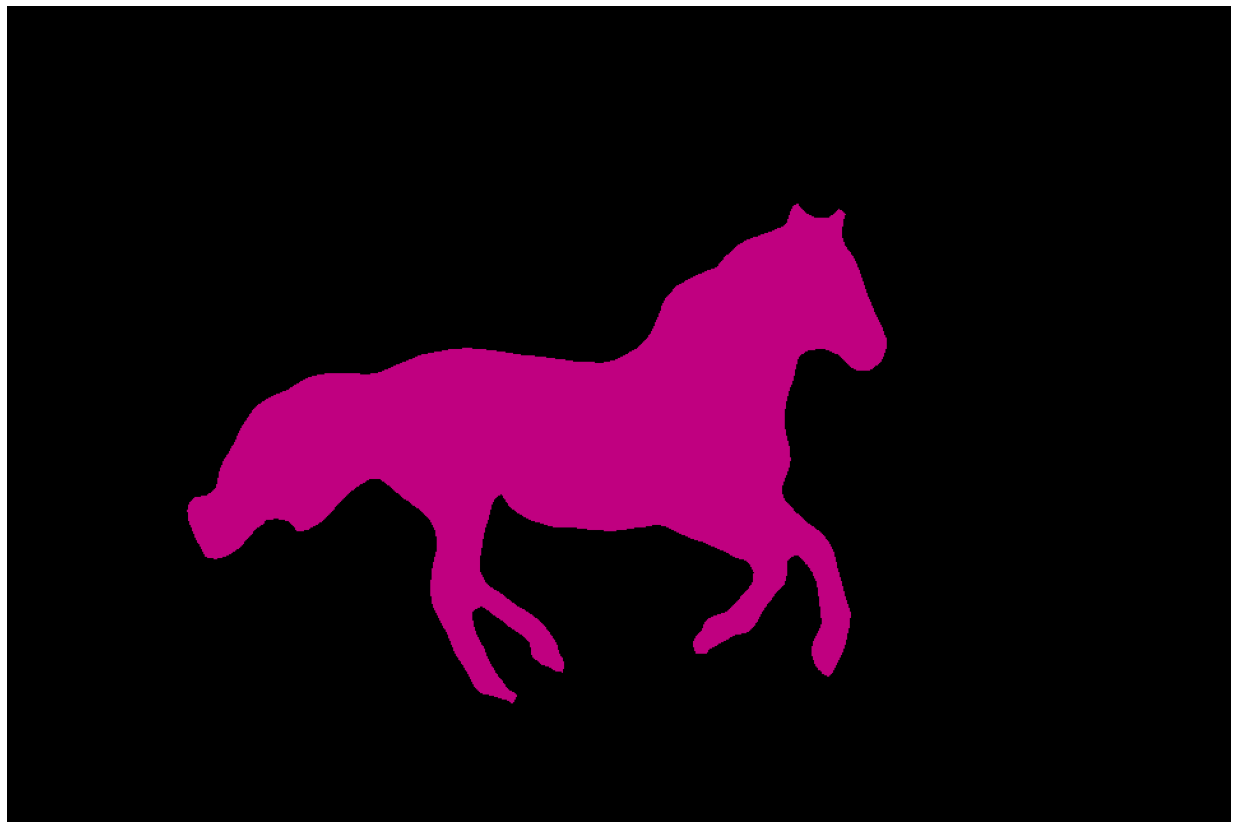

In [51]:
!wget -nv https://www.learnopencv.com/wp-content/uploads/2021/01/horse-segmentation.jpeg -O horse.png
segment(deeplabv3, './horse.png')